In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '[CS590W] Final Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/[CS590W] Final Project


In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
import os
import glob
import re
import math
import numpy as np
import pandas as pd
import cv2
import sys

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC

In [ ]:
data_directory = './dataset'

IMAGE_SIZE = 128
NUM_IMAGES = 32
BATCH_SIZE = 4
# BATCH_SIZE = 8

mri_types = ['FLAIR'] #['FLAIR', 'T1w', 'T1wCE', 'T2']

In [ ]:
train_df = pd.read_csv('./dataset/train_labels.csv')

to_exclude = [109, 123, 709]
train_df = train_df[~train_df['BraTS21ID'].isin(to_exclude)]

train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]

In [ ]:
print(len(train_df))
train_df.head()

582


,BraTS21ID,MGMT_value,BraTS21ID5
0,0,1,00000
1,2,1,00002
2,3,0,00003
3,5,1,00005
4,6,1,00006


# Data analyzing:
The goal of this is to determine how many images (channels) we should use to construct our input for CNN model.

In [ ]:
def count_images(split='train', mri_type='FLAIR'):
  path = os.path.join(data_directory, split)
  patients = os.listdir(path)
  images_count = []

  for patient in patients:
    if patient in ['00109', '00123', '00709']:
      continue
    patient_path = os.path.join(path, patient, mri_type)
    count = len(os.listdir(patient_path))
    images_count.append(count)
    if len(images_count) % 50 == 0 or len(images_count) == len(patients)-3:
      print('# of patients images count: {}/{}'.format(len(images_count), len(patients)-3)) # exclude 3 cases  
  
  return images_count


In [ ]:
mri_type = 'FLAIR'
train_dataset_count = count_images(split='train', mri_type=mri_type)

# of patients images count: 50/582
# of patients images count: 100/582
# of patients images count: 150/582
# of patients images count: 200/582
# of patients images count: 250/582
# of patients images count: 300/582
# of patients images count: 350/582
# of patients images count: 400/582
# of patients images count: 450/582
# of patients images count: 500/582
# of patients images count: 550/582
# of patients images count: 582/582


Min # of images: 15
Average # of images: 127


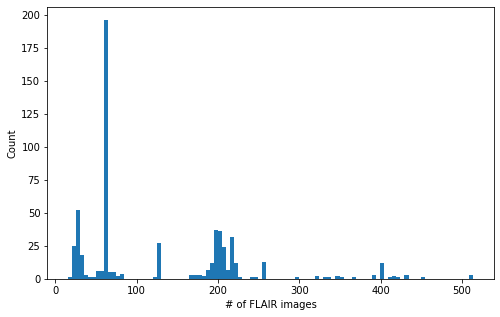

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(train_dataset_count,100)
plt.xlabel('# of {} images'.format(mri_type))
plt.ylabel('Count')
print('Min # of images: {}'.format(np.min(np.array(train_dataset_count))))
print('Average # of images: {:.0f}'.format(np.mean(np.array(train_dataset_count))))

In this project, we decide to use 32 images (channels). 

# Function to load images

## Data Augenmentation

In [ ]:
def apply_rotation(img, rotation_choice):
  rotations = [cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE]
  img = cv2.rotate(img, rotations[rotation_choice])
  
  return img

In [ ]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
  '''
  Load the raw image and apply rotation.
  '''
  dicom = pydicom.read_file(path)
  data = dicom.pixel_array
  if voi_lut:
    data = apply_voi_lut(dicom.pixel_array, dicom)
  else:
    data = dicom.pixel_array
  
  # Image rotation is hyperparameter
  if rotate > 0:
    data = apply_rotation(data, rotate)
  
  data = cv2.resize(data, (img_size, img_size))

  return data

## Data Loading

In [ ]:
def get_images(mid, imgs_needed, files):
  start = max(0, mid - (imgs_needed//2))
  end = min(len(files), mid + (imgs_needed//2))

  return files[start : end]

In [ ]:
def normalize_image(imgs):
  if np.min(imgs) < np.max(imgs):
    imgs = imgs - np.min(imgs)
    imgs = np.divide(imgs, np.max(imgs)) # numerical stability
  
  return imgs

In [ ]:
def load_dicom_images(patient_id, split='train', mri_type='FLAIR', num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, rotate=0):
  '''
  Select N images from each patient's total scans (include all mri_types). It follows the algorithm below:
  (1). Choose the middle image and expand on both side (N//2 images on each side).
  (2). If there's not enough images, repeat the first step and expand on both side (N//4 images on each side)
  (3). If there's still not enough images, apply 'zero-padding' on both ends.
  '''
  files = sorted(glob.glob(f"{data_directory}/{split}/{patient_id}/{mri_type}/*.dcm"),
                 key=lambda var: [int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])


  img_files = get_images(len(files)//2, num_imgs, files)

  img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in img_files]).T

  # print(img3d.shape[-1])
  
  if img3d.shape[-1] < num_imgs:
    zero_padding_front = np.zeros((img_size, img_size, (num_imgs - img3d.shape[-1]) // 2))
    zero_padding_back = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1] - zero_padding_front.shape[-1]))

    img3d = np.concatenate((zero_padding_front, img3d, zero_padding_back), axis=-1)  

  img3d = normalize_image(img3d)

  result = np.expand_dims(img3d, 0) # pytorch.unsqueeze(0)
  assert result.shape == (1, 128, 128, num_imgs) # (C, H, W, D)

  return result 


In [ ]:
def load_dicom_images_all(patient_id, split='train'):
  '''
  Load all the images from all mri_type of scans given patient_id
  '''
  img3d_all = np.concatenate([load_dicom_images(patient_id, split, mri_type) for mri_type in mri_types], axis=-1)

  return img3d_all

In [ ]:
a = load_dicom_images_all('00000', 'train')
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 128, 128, 32)
0.0 1.0 0.08089016540898764 0.00024458417490099706


# Dataloader

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class Dataloader(Sequence):
  def __init__(self, df, split='train', is_train=True, batch_size=BATCH_SIZE, shuffle=True):
    self.idx = df['BraTS21ID'].values
    self.paths = df['BraTS21ID5'].values
    self.y = df['MGMT_value'].values
    self.is_train = is_train
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.split = split
  
  def __len__(self):
    return math.ceil(len(self.idx) / self.batch_size)
  
  def __getitem__(self, ids):
    '''
    Input: 
      ids: starting index
    
    Output:
      - Batch_X: (batch_size, H, W, D, C=1)
      - batch_y: (batch_size,) or None
    '''
    patient_id = self.paths[ids]
    batch_patients_id = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]

    if self.y is not None:
      batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
    
    if self.split == 'train':
      list_x = [load_dicom_images_all(x, split='train') for x in batch_patients_id]
      batch_X = np.stack(list_x, axis=4)
    else:
      list_x = load_dicom_images_all(patient_id, split='train')
      batch_X = np.stack(list_x)
    
    batch_X = batch_X.transpose(4, 1, 2, 3, 0)
    # shape(batch_size, H, W, D, C=1)

    if self.is_train:
      return batch_X, batch_y
    else:
      return batch_X
    
  def on_epoch_end(self):
    if self.shuffle and self.is_train:
      ids_y = list(zip(self.idx, self.y))
      shuffle(ids_y)
      self.idx, self.y = list(zip(*ids_y))
  


## Data Splitting

In [ ]:
df_train, df_val = sk_model_selection.train_test_split(
    train_df,
    test_size = 0.2,
    random_state=12,
    stratify=train_df['MGMT_value']
)

df_val, df_test = sk_model_selection.train_test_split(
    df_val,
    test_size = 0.5,
    random_state=12,
    stratify=df_val['MGMT_value']
)

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
count = 0
for i in df_val['MGMT_value']:
  if(i == 1):
    count += 1
print(count/len(df_val))
print((58-count)/len(df_val))
df_train.head()

(465, 3)
(58, 3)
(59, 3)
0.5344827586206896
0.46551724137931033


,BraTS21ID,MGMT_value,BraTS21ID5
278,405,0,00405
446,645,0,00645
511,746,1,00746
46,71,1,00071
269,392,0,00392


In [ ]:
train_dataset = Dataloader(df_train, 'train')
val_dataset = Dataloader(df_val, 'train')

In [ ]:
# Load a simple batch size of 4
X_train, y_train = train_dataset[0]
X_val, y_val = val_dataset[0]

In [ ]:
# (C, H, W, D, batch_size)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(4, 128, 128, 32, 1)
(4,)
(4, 128, 128, 32, 1)
(4,)


# Plotting the data

In [ ]:
def plot_sample_all(images, label, j):
  plt.figure(figsize=(35,35))
  print('# of images: {}'.format(NUM_IMAGES))
  for i in range(NUM_IMAGES):
    plt.subplot(16,16,(i+1))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[j,:,:,i,0])
  
  plt.show()

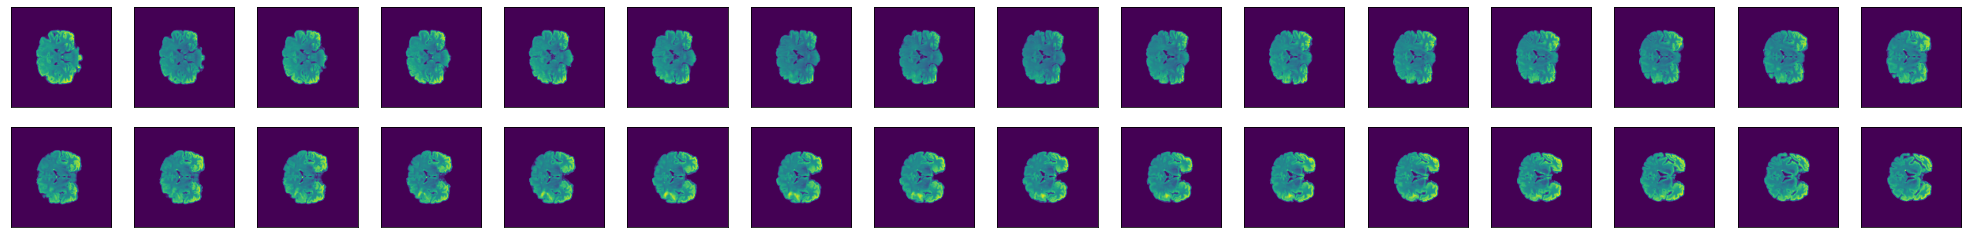

In [ ]:
i = 0
j = 1
images, label = train_dataset[i]
plot_sample_all(images, label, j)

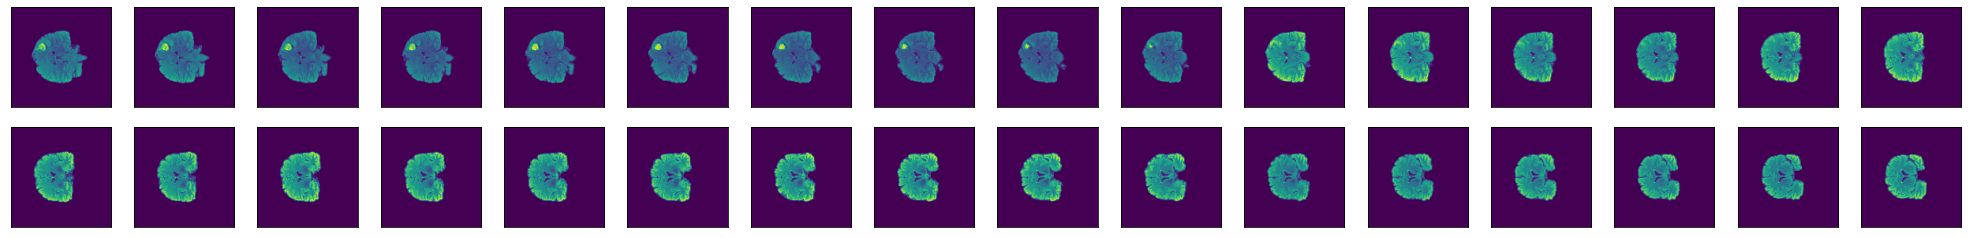

In [ ]:
j = 2
plot_sample_all(images, label, j)

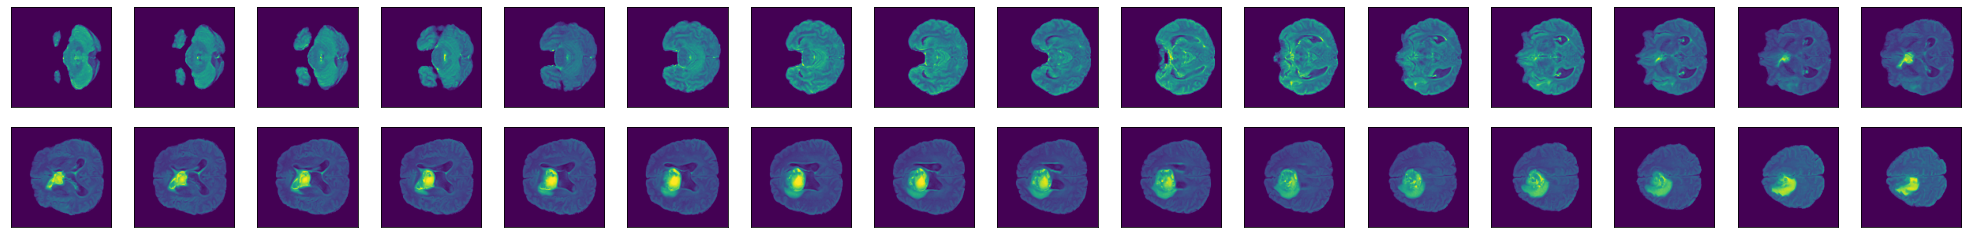

In [ ]:
i = 10
j = 0
images, label = train_dataset[i]
plot_sample_all(images, label, j)

# of images: 32


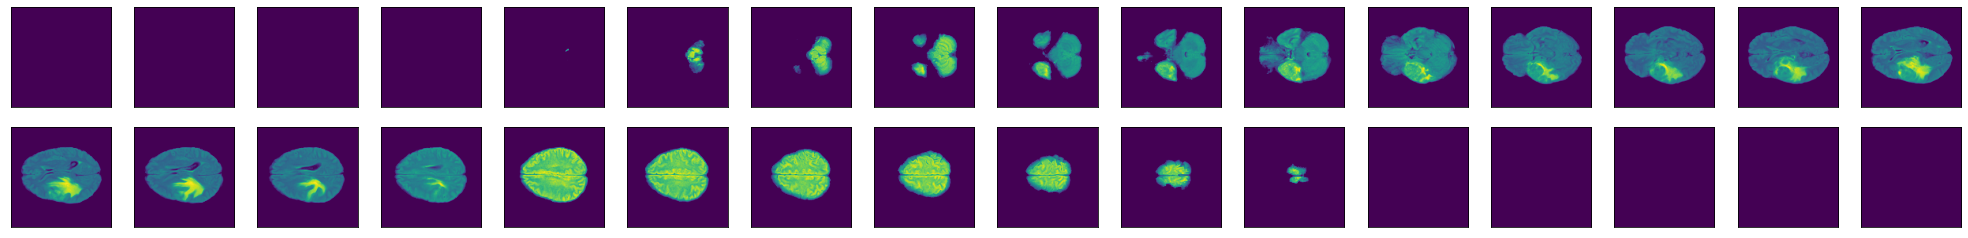

In [ ]:
plot_sample_all(images, label, 2)

In [ ]:
i = 1
images, label = train_dataset[i]

# of images: 32


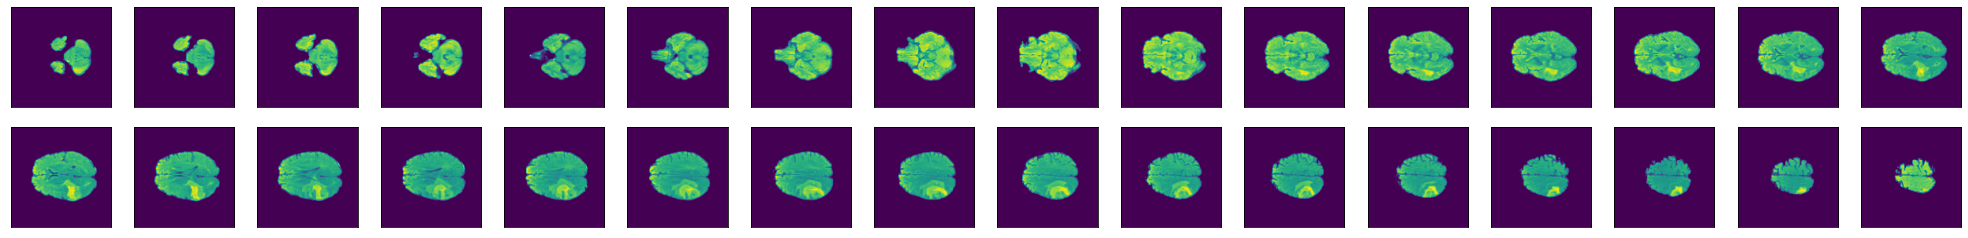

In [ ]:
plot_sample_all(images, label, 3)

## Sequence Animation

In [ ]:
import matplotlib.animation as animation
matplotlib.rcParams['animation.html'] = 'jshtml'

In [ ]:
def show_animation(images: list):
  fig, ax = plt.subplots()

  ims = []
  for i in range(NUM_IMAGES):
    im = ax.imshow(images[:,:,i,0], animated=True)
    if i == 0:
      ax.imshow(images[:,:,i,0])
    ims.append([im])
  print('Number of images: {}'.format(NUM_IMAGES) )
  ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
  plt.close()
  return ani


In [ ]:
animation = show_animation(images[3])
animation

Number of images: 32


In [ ]:
# animation.save('./figures/ani.mp4')

In [ ]:
show_animation(images[2])

Number of images: 32


# Dataloader for 2D CNN

## Data loading


In [ ]:
# def load_dicom_images_3d_2dcnn(scan_id, split='train', mri_type='FLAIR', num_imgs=64, img_size=IMAGE_SIZE, rotate=0):
#   '''
#   Select N images from each patient's total scans (include all mri_types). It follows the algorithm below:
#   (1). Choose the middle image and expand on both side (N//2 images on each side).
#   (2). If there's not enough images, repeat the first step and expand on both side (N//4 images on each side)
#   (3). If there's still not enough images, apply 'zero-padding' on both ends.
#   '''
#   def get_images(mid, imgs_needed, files):
#     start = max(0, mid - (imgs_needed)//2)
#     end = min(len(files), mid + (imgs_needed)//2)
    
#     return files[start:end]

#   files = sorted(glob.glob(f"{data_directory}/{'sample_'+split}/{scan_id}/{mri_type}/*.dcm"),
#                  key=lambda var: [int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
#   # print(num_imgs)
#   # print(len(files))
#   middle = len(files)//2

#   img_files = get_images(middle, num_imgs, files)

#   img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in img_files]).T

#   # print(img3d.shape[-1])

#   if img3d.shape[-1] <= num_imgs//2:
#     img_files = get_images(middle, num_imgs//2, files)
#     img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in img_files]).T
  
#   if img3d.shape[-1] < num_imgs:
#     zero_padding_front = np.zeros((img_size, img_size, (num_imgs - img3d.shape[-1]) // 2))
#     zero_padding_back = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1] - zero_padding_front.shape[-1]))

#     img3d = np.concatenate((zero_padding_front, img3d, zero_padding_back), axis=-1)
  
#   # Normalize:
#   if np.min(img3d) < np.max(img3d):
#     img3d -= np.min(img3d)
#     # img3d /= np.max(img3d)
#     img3d = np.divide(img3d, np.max(img3d))
  
#   # print(img3d.shape)
#   # result = np.expand_dims(img3d, 0) # pytorch.unsqueeze(0)
#   assert img3d.shape == (128, 128, 64) # (H,W,C)

#   return img3d

In [ ]:
# def load_dicom_images_3d_all_2dcnn(patient_id, split='train'):
#   '''
#   Load all the images from all mri_type of scans given patient_id
#   '''
#   img3d_all = np.concatenate([load_dicom_images_3d_2dcnn(patient_id, split, mri_type) for mri_type in mri_types], axis=-1)

#   return img3d_all

## Dataloader for 2D

In [ ]:
# class Dataloader2DCNN(Sequence):
#   def __init__(self, df, split='train', is_train=True, batch_size=BATCH_SIZE, shuffle=True):
#     self.idx = df['BraTS21ID'].values
#     self.paths = df['BraTS21ID5'].values
#     self.y = df['MGMT_value'].values
#     self.is_train = is_train
#     self.batch_size = batch_size
#     self.shuffle = shuffle
#     self.split = split
  
#   def __len__(self):
#     return math.ceil(len(self.idx) / self.batch_size)
  
#   def __getitem__(self, ids):
#     '''
#     Input: 
#       ids: starting index
    
#     Output:
#       - Batch_X: (batch_size, H, W, D, C=1)
#       - batch_y: (batch_size,) or None
#     '''
#     id_path = self.paths[ids]
#     batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
#     split = self.split
#     # print('hello')
#     if self.y is not None:
#       batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
    
#     if split == 'train':
#       list_x = [load_dicom_images_3d_all_2dcnn(x, split) for x in batch_paths]
#       batch_X = np.stack(list_x, axis=0)
#     else:
#       list_x = load_dicom_images_3d_all_2dcnn(id_path, split)
#       batch_X = np.stack(list_x)
    
#     # batch_X = batch_X.transpose(4, 1, 2, 3, 0)
    
#     # print(self.paths[ids])
#     if self.is_train:
#       return batch_X, batch_y # shape(batch_size, H, W, C=64)
#     else:
#       return batch_X

In [ ]:
# train_dataset_2DCNN = Dataloader2DCNN(df_train, 'train')
# # val_dataset = Dataloader(df_train, 'train')
# val_dataset_2DCNN = Dataloader2DCNN(df_val, 'train')

In [ ]:
# # load a simple batch size of 4
# X_train, y_train = train_dataset_2DCNN[0]
# X_val, y_val = val_dataset_2DCNN[0]

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

# Model

The architecture follows:\
[Conv Layer - BatchNormalization - LeakyReLU - (OPT) Max Pooling - (OPT) Dropout] $\times M$ --- [AveragePooling] --- [FC Layer - (OPT) Dropout] $\times N$ --- [FC Layer] --- [Sigmoid]\
where [$\cdot$]$\times M$ means repeats for $M$ times.

In [ ]:
train_dataset[0][0].shape

(4, 128, 128, 32, 1)

# Training the Model

## 2D CNN:

In [ ]:
# def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, channel=64):
#   '''
#   (1). You can add more Conv layers.
#   (2). You can add more intermediate layer in Conv layers e.g: maxpool3d but should be added once after 2-3 Conv layers
#   (3). Different activation function
#   (4). Dropout values

#   '''

#   inputs = keras.Input((width, height, channel))

#   # x = layers.Conv3D(filters=64, kernel_size=3)(inputs)
#   # x = layers.BatchNormalization()(x)
#   # x = layers.LeakyReLU()(x)

#   # x = layers.Conv3D(filters=128, kernel_size=3)(x)
#   # x = layers.BatchNormalization()(x)
#   # x = layers.LeakyReLU()(x) # can adjust alpha

#   x = layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', kernel_initializer='he_normal')(inputs)
#   x = layers.MaxPooling2D(pool_size=(2,2))(x)
#   x = layers.BatchNormalization()(x)

#   x = layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', kernel_initializer='he_normal')(x)
#   x = layers.MaxPooling2D(pool_size=(2,2))(x)
#   x = layers.Dropout(0.2)(x)
#   x = layers.BatchNormalization()(x)

#   x = layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', kernel_initializer='he_normal')(x)
#   x = layers.MaxPooling2D(pool_size=(2,2))(x)
#   x = layers.Dropout(0.25)(x)
#   x = layers.BatchNormalization()(x)
  
#   x = layers.Flatten()(x)

#   x = layers.Dense(100, activation='relu', kernel_initializer='he_normal')(x)
#   outputs = layers.Dense(units=1, activation='sigmoid')(x)


#   # x = layers.Dense(units=256, activation='relu')(x)
#   # x = layers.Dropout(0.2)(x)

#   # output is only 1 neuron: [0,1] applied sigmoid  
#   # x = layers.Dense(units=1, activation='sigmoid')(x)

#   model = keras.Model(inputs, outputs, name='2D_CNN')

#   return model

In [ ]:
# model = get_model()
# model.summary()

In [ ]:
# # initial_lr = 0.0001
# # initial_lr = 0.00001
# # initial_lr = 0.000001
# initial_lr = 0.001

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_lr, decay_steps=100000, decay_rate=0.98, staircase=True
# )

In [ ]:
# model.compile(loss='binary_crossentropy',
#               optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
#               metrics=[AUC(name='auc'), 'acc'] )

In [ ]:
# saved_models_path = './2D_saved_models/weights-improvement-{epoch:02d}-{val_auc:.2f}-{val_acc:.2f}.h5'
# checkpoint = ModelCheckpoint(saved_models_path,
#                              save_best_only=True,
#                              monitor= 'val_auc', # please check if can monitor by 'val_auc' instead
#                              mode='max', verbose=1)

# early_stopping = EarlyStopping(monitor='val_auc',
#                                patience=10,
#                                mode='max', verbose=1,
#                                restore_best_weights=True)

# callback_list = [checkpoint, early_stopping]

In [ ]:
# epochs = 5

# history = model.fit(
#     train_dataset_2DCNN,
#     validation_data = val_dataset_2DCNN,
#     epochs=epochs,
#     shuffle=True,
#     verbose=1,
#     callbacks = callback_list
# )

## 3D CNN:

In [ ]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=NUM_IMAGES):
  '''
  (1). You can add more Conv layers.
  (2). You can add more intermediate layer in Conv layers e.g: maxpool3d but should be added once after 2-3 Conv layers
  (3). Different activation function
  (4). Dropout values

  '''

  inputs = keras.Input((width, height, depth, 1))

  x = layers.Conv3D(filters=64, kernel_size=3)(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv3D(filters=128, kernel_size=3)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x) # can adjust alpha

  # x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(inputs)
  # x = layers.MaxPool3D(pool_size=2)(x)
  # x = layers.BatchNormalization()(x)

  # x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
  # x = layers.MaxPool3D(pool_size=2)(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.Dropout(0.02)(x)

  x = layers.GlobalAveragePooling3D()(x) # better than Flatten()

  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dropout(0.08)(x)

  # x = layers.Dense(units=256, activation='relu')(x)
  # x = layers.Dropout(0.2)(x)

  # output is only 1 neuron: [0,1] applied sigmoid  
  outputs = layers.Dense(units=1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs, name='3D_CNN')

  return model

In [ ]:
# model = get_model()
model = keras.models.load_model('./saved_models/weights-improvement-05-0.60-0.62.h5')
model.summary()

Model: "3D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 32, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 30, 64)  1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 30, 64)  256      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 30, 64)  0         
                                                                 
 conv3d_1 (Conv3D)           (None, 124, 124, 28, 128  221312    
                             )                                   
                                                            

In [ ]:
initial_lr = 0.001
# initial_lr = 0.0001
#initial_lr = 0.003

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=100000, decay_rate=0.98, staircase=True
)

We use binary crossenpory loss function and AUC metrics

In [ ]:
'''
You could use different optimizers
'''
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'), 'acc']
)
# model.compile(
#     loss='binary_crossentropy',
#     optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
#     metrics=[AUC(name='auc'), 'acc']
# )

In [ ]:
# Checkpoints and Early Stopping:

saved_models_path = './saved_models/weights-improvement-{epoch:02d}-{val_auc:.2f}-{val_acc:.2f}.h5'
checkpoint = ModelCheckpoint(saved_models_path,
                             save_best_only=True,
                             monitor= 'val_auc', # please check if can monitor by 'val_auc' instead
                             mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc',
                               patience=10,
                               mode='max', verbose=1,
                               restore_best_weights=True)

callback_list = [checkpoint, early_stopping]

In [ ]:
# train_dataset = Dataloader(df_train, 'train', batch_size=1)
# val_dataset = Dataloader(df_val, 'train', batch_size=1)
train_dataset = Dataloader(df_train, 'train', batch_size=8)
val_dataset = Dataloader(df_val, 'train', batch_size=8)
train_dataset[0][0].shape
val_dataset[0][0].shape

(8, 128, 128, 32, 1)

In [ ]:
epochs = 30

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = callback_list
)

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = './training_histories/weights-improvement-05-0.60-0.62.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

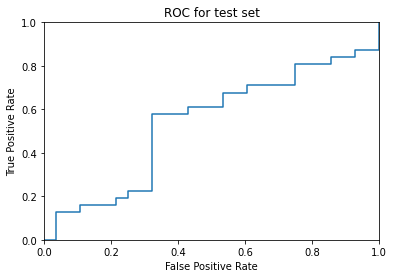

0.5357142857142857


In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score

test_dataset = Dataloader(df_test, 'train', batch_size=1, shuffle=False)
trained_model_1 = keras.models.load_model('./saved_models/weights-improvement-12-0.66-0.53.h5')
test_predict = trained_model_1.predict(test_dataset, batch_size=1)
print(trained_model_1.evaluate(test_dataset, batch_size=1))

labels = np.asarray([l[1] for l in test_dataset]).flatten()
normalized_predictions = np.where(test_predict >= 0.5, 1, 0)
print(accuracy_score(labels, normalized_predictions))

fpr, tpr, thresholds = roc_curve(labels, test_predict.ravel())

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate')
  plt.title('ROC for test set') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 
auc_score=auc(fpr, tpr)
print(auc_score)


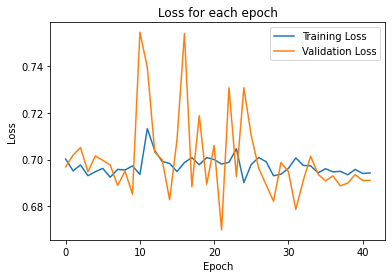

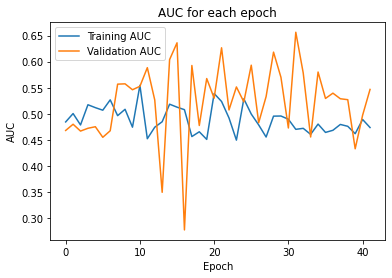

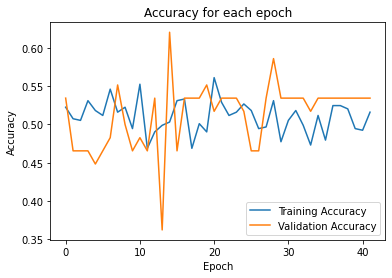

In [ ]:
ep1 = pd.read_csv('./training_histories/history.csv')
ep2 = pd.read_csv('./training_histories/history_weights-improvement-09-0.56-0.50.csv')
ep3 = pd.read_csv('./training_histories/weights-improvement-05-0.60-0.62.csv')

full_history = pd.concat([ep1, ep2, ep3])
epochs = range(len(full_history))

plt.plot(epochs, full_history['loss'], label='Training Loss')
plt.plot(epochs, full_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Loss for each epoch') 
plt.legend()
plt.show()

plt.plot(epochs, full_history['auc'], label='Training AUC')
plt.plot(epochs, full_history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch') 
plt.ylabel('AUC')
plt.title('AUC for each epoch') 
plt.legend()
plt.show()

plt.plot(epochs, full_history['acc'], label='Training Accuracy')
plt.plot(epochs, full_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')
plt.title('Accuracy for each epoch') 
plt.legend()
plt.show()